<a href="https://colab.research.google.com/github/tomdyer10/examples/blob/master/LR_explained.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This notebook introduces the concepts of the '1 cycle' policy for optimisation of Nueral network training hyperparameters.

"The art of setting the network's hyper-parameters amounts to ending up at the balancing point between underfitting and overfitting" - Leslie Smith

# Resources

**Useful resources on learning rate, cyclical learning rate and '1 cycle' policy:**

Original research paper:
- https://arxiv.org/abs/1803.09820

Fast AI blog post:
- https://sgugger.github.io/the-1cycle-policy.html

Accompanying python notebook:
- https://github.com/sgugger/Deep-Learning/blob/master/Cyclical%20LR%20and%20momentums.ipynb

Medium article reviewing 1 cycle policy research paper:
- https://towardsdatascience.com/finding-good-learning-rate-and-the-one-cycle-policy-7159fe1db5d6

Fast AI forum thread on cyclical momentum:
- https://forums.fast.ai/t/project-cyclical-momentum/14435


# What is Learning rate?

Learning rate is the 'step size' with which we adjust the weights of our algorithm in the training stage, during the process of Stochastic Gradient Descent (SGD).

Getting the correct learning rate helps minimise under/overfitting in our model.

This image shows the issues of a learning rate that is too large or too small:

![alt text](https://miro.medium.com/max/1600/1*n79s9gvd0E8ALe9dLUEKAw.png)

Traditional approaches find the perfect learning rate and keep this constant throught the training stage:

![alt text](https://developers.google.com/machine-learning/crash-course/images/LearningRateJustRight.svg)

# Setting Learning Rate

In [0]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

Load up a familiar computer vision problem

In [0]:
from fastai.vision import *
from fastai.metrics import error_rate

In [11]:
path = untar_data(URLs.PETS); path

PosixPath('/root/.fastai/data/oxford-iiit-pet')

In [0]:
path_anno = path/'annotations'
path_img = path/'images'

In [0]:
bs = 64

In [0]:
fnames = get_image_files(path_img)
np.random.seed(2)
pat = r'/([^/]+)_\d+.jpg$'
data = ImageDataBunch.from_name_re(path_img, fnames, pat, ds_tfms=get_transforms(),
                                   size=299, bs=bs//2).normalize(imagenet_stats)

In [21]:
print(data.classes)


['Abyssinian', 'Bengal', 'Birman', 'Bombay', 'British_Shorthair', 'Egyptian_Mau', 'Maine_Coon', 'Persian', 'Ragdoll', 'Russian_Blue', 'Siamese', 'Sphynx', 'american_bulldog', 'american_pit_bull_terrier', 'basset_hound', 'beagle', 'boxer', 'chihuahua', 'english_cocker_spaniel', 'english_setter', 'german_shorthaired', 'great_pyrenees', 'havanese', 'japanese_chin', 'keeshond', 'leonberger', 'miniature_pinscher', 'newfoundland', 'pomeranian', 'pug', 'saint_bernard', 'samoyed', 'scottish_terrier', 'shiba_inu', 'staffordshire_bull_terrier', 'wheaten_terrier', 'yorkshire_terrier']


In [0]:
#load model
learn = cnn_learner(data, models.resnet50, metrics=error_rate)

epoch,train_loss,valid_loss,error_rate,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


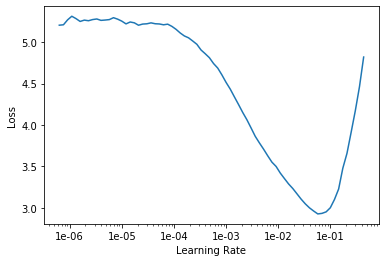

In [23]:
#find learning rate and plot results
learn.lr_find()
learn.recorder.plot()

**How does this work?**

lr_find will train the learner over a few iterations, starting with very low learning rate (lr) and ending with a very high lr. Recorder will record the model loss of each iteration and plot these losses.

We are looking for an order of magnitude of learning rate so we plot a logarithmic scale.

**Choosing a good learning rate:**
We want to choose a value which is roughly in the middle of the sharpest downward slope (with the largest negative gradient for model loss)

By passing suggestion=True into our learn.recorder.plot(), we can display a point at the steepest gradient.



Min numerical gradient: 3.02E-03
Min loss divided by 10: 5.75E-03


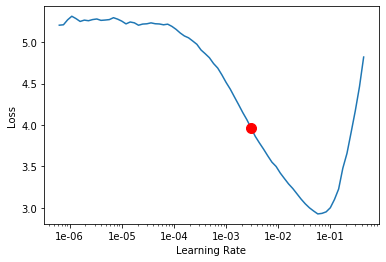

In [24]:
learn.recorder.plot(suggestion=True)

We can now fit this model based on the optimal learning rate that lr_find has determined:

In [25]:
learn.fit(8, 1e-03)

epoch,train_loss,valid_loss,error_rate,time
0,0.514219,0.228790,0.072395,02:23
1,0.381864,0.248170,0.078484,02:22
2,0.302446,0.218735,0.067659,02:22
3,0.271777,0.214233,0.061570,02:22
4,0.241804,0.231466,0.069012,02:20
5,0.199389,0.233813,0.067659,02:22
6,0.171323,0.198591,0.064953,02:21
7,0.175570,0.197474,0.062246,02:20


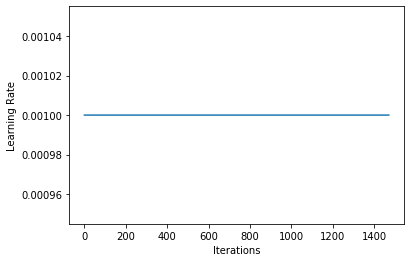

In [28]:
#here we can see our learning rate stayed constant throughout training
learn.recorder.plot_lr()

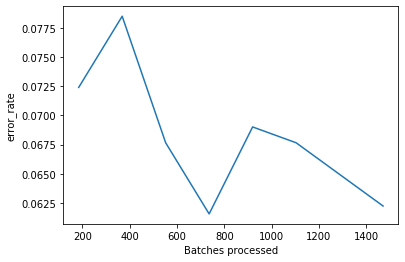

In [30]:
#plot error rate
learn.recorder.plot_metrics()

This model performance is based on a constant learning rate

# Cyclical Learning Rate

If LR is too small, the model can overfit and training is very slow. However, if the LR is too large, the model can diverge (see first image).


Cyclical Learning Rates (CLR) uses a combination of high and low learning rates to improve model training. Higher learning rates will help models get out of saddle points. Lower learning rates will help the model converge.

CLR happens in cycles where a cycle is the number of iterations where we go from lower bound learning rate to higher bound and back to lower bound. Cycle may not have boundary on epoch, but in practice it usually does. Stepsize is half of cycle. So Stepsize is number of iterations where we want learning rate to go from one bound to the other.

![alt text](https://miro.medium.com/max/784/1*fI0l_gIezdHLFlZpJ2s8iA.png)



# One Cycle Policy

The one cycle policy is introduced by the 2018 paper by Leslie Smith, where he suggests a modification of CLR where only one cycle is used that is smaller than the total number of iterations/epochs and allow learning rate to decrease several orders of magnitude less than initial LR for the remaining iterations.

This means the learning rate looks like this:

![alt text](https://sgugger.github.io/images/art5_lr_schedule.png)

This can be easily accessed by fast ai using the fit_one_cycle method:

In [43]:
learn = cnn_learner(data, models.resnet50, metrics=error_rate)
learn.lr_find()
learn.fit_one_cycle(8)

epoch,train_loss,valid_loss,error_rate,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


epoch,train_loss,valid_loss,error_rate,time
0,0.702489,0.284735,0.092693,02:22
1,0.522114,0.272576,0.081867,02:22
2,0.469177,0.246410,0.080514,02:21
3,0.302803,0.193158,0.060893,02:21
4,0.265929,0.176544,0.051421,02:19
5,0.216269,0.166456,0.050068,02:20
6,0.119575,0.149753,0.041949,02:19
7,0.101975,0.150364,0.045332,02:19


In [0]:
#fine tune with more specific min and max lr


# Cyclical Momentum

Momentum is very similar to learning rate, it is a factor which influences the way a weight is updated in our network. 

![alt text](https://miro.medium.com/max/878/1*KOBqwaaawtFwHW5uvLr26g.png)

Optimal momentum values will improve model training. In the fast ai fit_one_cycle moment looks like this:
![alt text](https://sgugger.github.io/images/art5_full_schedule.png)

Mirroring the learning rate so as not to pseudo-accelerate the training.